In [27]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools

# reading in all the data
data = pd.read_csv('DG-AssocMiner_miner-disease-gene-edited.tsv', sep='\t')
dg_edgedata = list(zip(data['# Disease ID'], data['Gene_Name']))            # edge list
disease_nodes = list(set(data['# Disease ID']))                             # disease node list
gene_nodes = list(data['Gene_Name'])                                        # gene node list
disease_namedata = set(list(zip(data['# Disease ID'], data['Disease Name'])))
disease_namedata = dict(disease_namedata)


Reducing the search space using the data from the Gene-Function network.      
This can be used to remove all the ubiquitous genes as their deletions are more likely to be fatal as compared to the other genes.       
(which also means that they cannot become diseases)
This threshold is debatable, currently set to 0.0005      


In [28]:
# pruning the gene search space

gene_function_data = pd.read_csv('GF-Miner_miner-gene-function.tsv', sep = '\t')
gf_edgedata = list(zip(gene_function_data['# GO_ID'], gene_function_data['Gene']))
gf_graph = nx.Graph()
gf_graph.add_edges_from(gf_edgedata)
deg_cents_gf = nx.degree_centrality(gf_graph)
gene_nodes_gf = list(set(gene_function_data['Gene']))

gene_cents = [(i, deg_cents_gf[i]) for i in deg_cents_gf.keys() if i in gene_nodes_gf]
gene_cents = sorted(gene_cents, key=lambda x: x[1], reverse = True)

a = np.empty([1, len(gene_cents)])
for dc in range(len(gene_cents)):
    np.append(a, gene_cents[dc][1])

ignore_thr = np.percentile(a, 99)
ign_genes = [i[0] for i in gene_cents if i[1] > ignore_thr]      # removing all nodes with higher degree centralities

print(ign_genes)

gene_nodes_gf = [i for i in gene_nodes_gf if i not in ign_genes]    

print('before pruning',len(dg_edgedata))
dg_edgedata = [i for i in dg_edgedata if i[1] not in ign_genes]
print('after pruning',len(dg_edgedata))
disease_nodes = list(set([i[0] for i in dg_edgedata]))

['NRP1', 'FGF10', 'BMP4', 'LGALS9', 'TLR4', 'CITED2', 'SOD2', 'PARK2', 'DMD', 'TGFB1', 'CD24', 'CTNNB1', 'APOE', 'DLL1', 'FGF2', 'TNF', 'PTPN22', 'PPP1R9B', 'SLC9A3R1', 'AGT', 'WNT5A', 'TSPO', 'MYD88', 'GATA3', 'WNT7A', 'OGT', 'PARK7', 'FSHR', 'TERT', 'NOTCH1', 'GHR', 'CCL21', 'KLF4', 'PPP1R15A', 'SHH', 'MEN1', 'GREM1', 'APOA1', 'EDN1', 'HMGA2', 'SNAI2', 'ACTN3', 'FOXP1', 'SNCA', 'ADA', 'JAK2', 'CRH', 'HMGB1', 'SLC11A2', 'EHD1', 'CYR61', 'BCL2L11', 'LRP6', 'IL4', 'LYN', 'GJA5', 'CCL5', 'MTOR', 'ABCA1', 'ITGB1BP1', 'RAPGEF3', 'IL1B', 'DRD2', 'SHTN1', 'INS', 'GLI3', 'PDE2A', 'DDX3X', 'DVL1', 'AQP9', 'TCF21', 'SLC25A17', 'KDM1A', 'ITGB1', 'BCL2', 'SRF', 'PTPN2', 'AQP1', 'PTGER4', 'SOX9', 'AK9', 'SCN5A', 'EHMT2', 'IRG1', 'DNM1L', 'TLR3', 'PDGFRB', 'PIK3CD', 'NFIB', 'TOR1A', 'TNFSF11', 'CASQ2', 'AXIN1', 'TCAP', 'SLIT2', 'SERPINA5', 'ADRB2', 'CCR7', 'LHX1', 'PCDH15', 'ATM', 'GSN', 'CACNA1G', 'FASN', 'CNOT1', 'BMPR1B', 'CASR', 'HNF1A', 'WNT10B', 'TBX3', 'DKK1', 'SIX3', 'ANXA1', 'WNT1', 'TNFAI

In [29]:
display(dg_edgedata)

[('C0036095', 'VCAN'),
 ('C0036095', 'DAPK1'),
 ('C0036095', 'MARK2'),
 ('C0036095', 'EN1'),
 ('C0036095', 'FANCA'),
 ('C0036095', 'FAT1'),
 ('C0036095', 'ZIM2'),
 ('C0036095', 'GAS2'),
 ('C0036095', 'PCSK1N'),
 ('C0036095', 'GUCY1A1'),
 ('C0036095', 'KRT5'),
 ('C0036095', 'KRT15'),
 ('C0036095', 'IRX4'),
 ('C0036095', 'DTL'),
 ('C0036095', 'BCL11A'),
 ('C0036095', 'STAG3L1'),
 ('C0036095', 'MIER2'),
 ('C0036095', 'SLC24A3'),
 ('C0036095', 'PYGB'),
 ('C0036095', 'SON'),
 ('C0036095', 'EFHD1'),
 ('C0036095', 'WNT5B'),
 ('C0036095', 'HOMER3'),
 ('C0033941', 'ADORA2A'),
 ('C0033941', 'HTR6'),
 ('C0033941', 'SLC6A3'),
 ('C0043459', 'PEX6'),
 ('C0043459', 'PEX10'),
 ('C0043459', 'PEX13'),
 ('C0043459', 'PEX2'),
 ('C0043459', 'PEX11B'),
 ('C0033860', 'PSORS4'),
 ('C0033860', 'HCP5'),
 ('C0033860', 'TAGAP'),
 ('C0033860', 'ZNF816'),
 ('C0033860', 'CP'),
 ('C0033860', 'PSORS8'),
 ('C0033860', 'IL23R'),
 ('C0033860', 'CYP2S1'),
 ('C0033860', 'LCE3B'),
 ('C0033860', 'LCE3C'),
 ('C0033860', 'PSOR

In [30]:
# making the disease gene association network

DG_graph = nx.Graph()
DG_graph.add_edges_from(dg_edgedata)
# DG_graph.nodes

In [31]:
# function for getting a weighted projection of the disease gene association network. 
# this will give a specific network of disease nodes with edge weights being the number of genes shared between them 

from itertools import combinations
def get_edge_wt_projection(graph, nodes):
    
    nodes = list(set(nodes))
    wt_prj = nx.Graph()
    combs = combinations(nodes, 2)
    prj = nx.bipartite.projected_graph(graph, nodes)
    wt_prj.edges.data('weight', default=1)
    for comb in combs:
        if comb in prj.edges:
            # count how many nodes are common between the neighbourhoods of the two nodes
            n1 = set(list(graph.neighbors(comb[0]))) 
            n2 = set(list(graph.neighbors(comb[1])))
            intrsct = n1.intersection(n2)
            wt_prj.add_edge(comb[0], comb[1], weight=len(intrsct))     # add weighted edge to the graph 
    
    return wt_prj

disease_projection = get_edge_wt_projection(DG_graph, disease_nodes)

In [32]:
# write to csv file
nx.write_weighted_edgelist(disease_projection, 'disease_projection.csv')


In [33]:
# finding eigenvector centralities of the nodes
disease_ev_cents = (nx.eigenvector_centrality(disease_projection, max_iter=1000)).items()

# finding degree centralities of the nodes 
disease_dg_cents = (nx.degree_centrality(disease_projection)).items()

eigenvector centrality is not really useful as it doesn't take into account the importance of the connections between two nodes. (information regarding edge weights not being used)

Vertex strength is a better parameter. 

vertex strength is defined as degree times the weight of edges incident on the node. 

(reference: https://doi.org/10.1073/pnas.0400087101)


In [34]:
# calculating the vertex strength of the nodes in the graph
def get_vertex_strength(graph):
    adj = (nx.adjacency_matrix(graph)).todense()           # todense() is for making it into an actual matrix
    n = len(graph.nodes)
    vertex_st = {}
    nodes = list(graph.nodes)

    for i in nodes:    
        
        vertex_st[i] = 0
        for j in nodes:
            # try except block to prevent keyerror from trying to find non-existent edge. 
            try:
                vertex_st[i] += graph[i][j]['weight'] * adj[nodes.index(i), nodes.index(j)]  
            except KeyError:
                pass

    return vertex_st

vertex_st = get_vertex_strength(disease_projection)
vertex_st_items = vertex_st.items()
vertex_st = {k: v for k, v in sorted(vertex_st_items, key=lambda item: item[1])}

# vertex_st_items is a variable which has tuples of the format (node_id, vertex_strength)

In [35]:
# combining all the data into a dataframe

combined_data = pd.DataFrame(columns =['disease ID', 'deg_cent','ev_cent', 'vertex_st'])
combined_data['disease ID'] = [i[0] for i in disease_ev_cents]
combined_data['deg_cent'] = [i[1] for i in disease_dg_cents]
combined_data['ev_cent'] = [i[1] for i in disease_ev_cents]
combined_data['vertex_st'] = [i[1] for i in vertex_st_items]
combined_data.head()

,disease ID,deg_cent,ev_cent,vertex_st
0,C0403553,0.011765,0.004528,6
1,C0028754,0.327451,0.132401,609
2,C0339527,0.011765,0.002173,33
3,C0752166,0.011765,0.004774,6
4,C0265275,0.015686,0.003458,8


In [36]:
# product score
combined_data['product'] = combined_data.deg_cent * combined_data.ev_cent

combined_data['ratio'] = combined_data.deg_cent/combined_data.ev_cent
# Think of some other metric that can be used. 

In [61]:
# sort combined data by vertex strength
combined_data = combined_data.sort_values(by = 'vertex_st', ascending = False)

# map to disease names 
combined_data['disease name'] = combined_data['disease ID'].map(disease_namedata)
combined_data[:20]

,disease ID,deg_cent,ev_cent,vertex_st,product,ratio,disease name
32,C1458155,0.431373,0.179837,3112,0.077577,2.398683,Mammary Neoplasms
54,C0151786,0.103922,0.057298,3100,0.005955,1.813688,Muscle Weakness
71,C0013080,0.105882,0.063227,3096,0.006695,1.674631,Down Syndrome
39,C0024668,0.198039,0.103296,2861,0.020457,1.917209,"Mammary Neoplasms, Experimental"
37,C0024667,0.188235,0.097614,2795,0.018374,1.928371,Animal Mammary Neoplasms
45,C0038356,0.264706,0.123247,2201,0.032624,2.147770,Stomach Neoplasms
59,C0033578,0.370588,0.155512,1751,0.057631,2.383028,Prostatic Neoplasms
270,C1272641,0.127451,0.065764,1645,0.008382,1.938011,Systemic arterial pressure
265,C1271104,0.127451,0.065764,1645,0.008382,1.938011,Blood pressure finding
130,C0242656,0.115686,0.065580,1490,0.007587,1.764056,Disease Progression


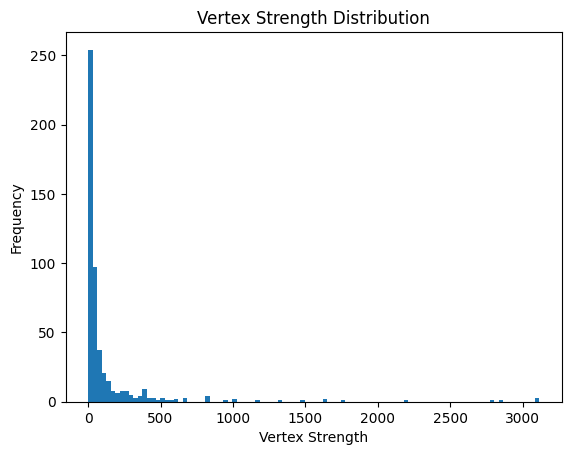

In [37]:
# plotting the vertex strength distribution

import matplotlib.pyplot as plt
plt.hist(combined_data['vertex_st'], bins = 100)
plt.xlabel('Vertex Strength')
plt.ylabel('Frequency')
plt.title('Vertex Strength Distribution')
plt.show()

In [66]:
# sort the edges according to the weights
sortededges = sorted(disease_projection.edges(data = True), key = lambda x: x[2]['weight'], reverse=True)
top10 = sortededges[:10]
# map these to disease names
top10 = [(i[0], i[1], i[2]['weight']) for i in top10]
top10 = [(disease_namedata[i[0]], disease_namedata[i[1]], i[2]) for i in top10]
display(top10)

# find the inverse comorbidity relations
bottom10 = sortededges[-10:]
bottom10 = [(i[0], i[1], i[2]['weight']) for i in bottom10]
bottom10 = [(disease_namedata[i[0]], disease_namedata[i[1]], i[2]) for i in bottom10]
display(bottom10)

sorted_data = pd.DataFrame(sortededges, columns = ['Disease1', 'Disease2', 'Weight'])
# sorted_data.loc[sorted_data['Disease1'] == 'C0030567']

[('Muscle Weakness', 'Down Syndrome', 55),
 ('Animal Mammary Neoplasms', 'Mammary Neoplasms, Experimental', 50),
 ('Blood pressure finding', 'Systemic arterial pressure', 38),
 ('Stomach Neoplasms', 'Disease Progression', 37),
 ('Arsenic Poisoning', 'Dermatologic disorders', 24),
 ('Adenoid Cystic Carcinoma', 'Salivary Gland Neoplasms', 23),
 ('Liver Neoplasms, Experimental', 'Precancerous Conditions', 22),
 ('Mammary Neoplasms', 'Neoplasm Metastasis', 19),
 ('hearing impairment', 'Hearing Loss, Partial', 19),
 ('Mammary Neoplasms', 'Colorectal Neoplasms', 18)]

[('Venous Thrombosis', 'Sepsis', 1),
 ('Thromboembolism', 'Sepsis', 1),
 ('Hydrops Fetalis, Non-Immune', 'beta Thalassemia', 1),
 ('Hydrops Fetalis, Non-Immune', 'Myoclonic Epilepsies, Progressive', 1),
 ('Hydrops Fetalis, Non-Immune', 'Finding of Mean Corpuscular Hemoglobin', 1),
 ('Absence Epilepsy', 'Idiopathic generalized epilepsy', 1),
 ('Left ventricular noncompaction',
  'Cardiomyopathy, Familial Hypertrophic, 1 (disorder)',
  1),
 ('Electrocardiogram: P-R interval', 'Neuralgia', 1),
 ('Infant length', 'Birth Weight', 1),
 ('Fetal Growth Retardation', 'Birth Weight', 1)]

## Clustering

Louvain algorithm for community detection uses modularity as a metric to form clusters

In [39]:
from scipy.sparse import csr_matrix

adj_sparse = csr_matrix(nx.adjacency_matrix(disease_projection))          # sending sparse

from sknetwork.clustering import Louvain
louvain = Louvain()

labels_dp = louvain.fit_predict(adj_sparse)

# print(labels_dp)
#print(len(labels))

#output has serial number of node as clusters
clusters = [[] for _ in range(len(set(labels_dp)))]
for index, value in enumerate(labels_dp):
    clusters[value].append(index)
    
temp_nodes = []
# get the disease nodes that are in the clusters
for cluster in clusters:
    temp = []
    for i in cluster:
        node_id = disease_nodes[i]
        temp.append(node_id)
    temp_nodes+=temp

disease_nodes = temp_nodes

proba = louvain.predict_proba()

# map the clusters to the disease IDs
cluster_map = {}
for i, sublist in enumerate(clusters):
    for j in sublist:
        cluster_map[disease_nodes[j]] = i

temp2 = []
clusters_w_id = []
# convert to frozenset for easy comparison
for cluster in clusters:
    temp = []
    for i in range(len(cluster)):
        node_id = disease_nodes[i]
        temp.append(node_id)
    temp2.append(temp)

for i in range(len(temp2)):
    clusters_w_id.append(frozenset(temp2[i]))



In [40]:
# now we need to find the diseases that are inversely comorbid
# we can do this by finding the diseases that are in the same cluster but have a low edge weight
# this is because the edge weight is the number of genes shared between the two diseases
# if the diseases are in the same cluster but have a low edge weight, it means that they are inversely comorbid

# we need to find the threshold for the edge weight
# we can do this by finding the average edge weight in the graph
# and then finding the average edge weight in each cluster
# then we can find the ratio of the average edge weight in the cluster to the average edge weight in the graph
# this will give us an idea of how much the average edge weight in the cluster deviates from the average edge weight in the graph
# we can then use this ratio as a threshold to find the inversely comorbid diseases

# find the average edge weight in the graph
total_edge_weight = 0
for edge in disease_projection.edges(data = True):
    total_edge_weight += edge[2]['weight']
average_edge_weight = total_edge_weight/len(disease_projection.edges)
print(average_edge_weight)

# find the average edge weight in each cluster using cluster_map
cluster_edge_weights = {}
for edge in disease_projection.edges(data = True):
    try:
        if cluster_map[edge[0]] == cluster_map[edge[1]]:
            if cluster_map[edge[0]] in cluster_edge_weights:
                cluster_edge_weights[cluster_map[edge[0]]] += edge[2]['weight']
            else:
                cluster_edge_weights[cluster_map[edge[0]]] = edge[2]['weight']
    except KeyError:
        pass

for i in cluster_edge_weights:
    cluster_edge_weights[i] = cluster_edge_weights[i]/len(clusters[i])

print('cluster_edge_weights:', cluster_edge_weights)

# find the ratio of the average edge weight in the cluster to the average edge weight in the graph
cluster_edge_weight_ratios = {}
for i in cluster_edge_weights:
    cluster_edge_weight_ratios[i] = cluster_edge_weights[i]/average_edge_weight
print('cluster_edge_weight_ratios:', cluster_edge_weight_ratios)

# find the inversely comorbid diseases
inversely_comorbid_diseases = []
for edge in disease_projection.edges(data = True):
    try:
        if cluster_map[edge[0]] == cluster_map[edge[1]] and edge[2]['weight'] < average_edge_weight:
            inversely_comorbid_diseases.append((edge[0], edge[1], edge[2]['weight']))
    except KeyError:
        pass
print(len(inversely_comorbid_diseases))
print(len(disease_projection.edges))


1.4205141003244321
cluster_edge_weights: {1: 6.741071428571429, 3: 0.8833333333333333, 0: 5.296, 2: 3.7662337662337664, 5: 0.7368421052631579, 7: 0.3333333333333333, 6: 0.9090909090909091, 4: 2.411764705882353, 8: 0.2}
cluster_edge_weight_ratios: {1: 4.745515322256802, 3: 0.6218405949871164, 0: 3.728227687983135, 2: 2.651317410628725, 5: 0.518715094130266, 7: 0.23465682829702506, 6: 0.6399731680827957, 4: 1.6978111694431814, 8: 0.14079409697821504}
1064
8014


In [71]:
# how do i confirm that these are inverse comorbids and not comorbids
# for these disease pairs, i can check the overlapping neighbourhood of the two diseases in the disease gene network
# if the overlapping neighbourhood contains a big fraction of the genes in the neighbourhood of the each of the two diseases separately
# then it is likely that these diseases are inversely comorbid

# find the overlapping neighbourhood of the two diseases
def get_neighbourhood(graph, node):
    neighbourhood = set(list(graph.neighbors(node)))
    return neighbourhood

def get_overlapping_neighbourhood(graph, node1, node2):
    neighbourhood1 = get_neighbourhood(graph, node1)
    neighbourhood2 = get_neighbourhood(graph, node2)
    overlapping_neighbourhood = neighbourhood1.intersection(neighbourhood2)
    return overlapping_neighbourhood

# find the fraction of the genes in the overlapping neighbourhood that are in the neighbourhood of each of the two diseases separately
def overlap_fraction(graph, node1, node2):
    f1 = len(get_overlapping_neighbourhood(graph, node1, node2))/len(get_neighbourhood(graph, node1))
    f2 = len(get_overlapping_neighbourhood(graph, node1, node2))/len(get_neighbourhood(graph, node2))
    return f1, f2

of_values = []          # calculating the overlap fraction values for all the inversely comorbid diseases
for disease_pair in inversely_comorbid_diseases:
    f1, f2 = overlap_fraction(disease_projection, disease_pair[0], disease_pair[1])
    of_values.append((disease_pair[0], disease_pair[1], f1*f2))

of_values = sorted(of_values, key = lambda x: x[2], reverse=True)
of_values[:10]

[('C0024796', 'C0005944', 0.5925925925925926),
 ('C0004134', 'C0006111', 0.5877777777777778),
 ('C0036202', 'C0042109', 0.5633333333333334),
 ('C0011849', 'C0032914', 0.4809090909090909),
 ('C0004134', 'C0497327', 0.4765765765765766),
 ('C1319853', 'C0036202', 0.46944444444444444),
 ('C0006111', 'C0497327', 0.436036036036036),
 ('C0017668', 'C0003504', 0.4224137931034483),
 ('C0019163', 'C0036202', 0.41728395061728396),
 ('C0007370', 'C0003123', 0.41538461538461535)]

In [72]:
# Map to disease names 

inv_com_dis = pd.DataFrame(of_values, columns = ['Disease 1', 'Disease 2', 'Overlap Fraction'])
inv_com_dis['Disease 1'] = inv_com_dis['Disease 1'].map(disease_namedata)
inv_com_dis['Disease 2'] = inv_com_dis['Disease 2'].map(disease_namedata)
inv_com_dis.loc[:50]




,Disease 1,Disease 2,Overlap Fraction
0,Marfan Syndrome,Metabolic Bone Disorder,0.592593
1,Ataxia,Brain Diseases,0.587778
2,Sarcoidosis,Urticaria,0.563333
3,Diabetes Mellitus,Pre-Eclampsia,0.480909
4,Ataxia,Dementia,0.476577
5,"Asthma, Aspirin-Induced",Sarcoidosis,0.469444
6,Brain Diseases,Dementia,0.436036
7,Focal glomerulosclerosis,Aortic Valve Insufficiency,0.422414
8,Hepatitis B,Sarcoidosis,0.417284
9,Catalepsy,Anorexia,0.415385


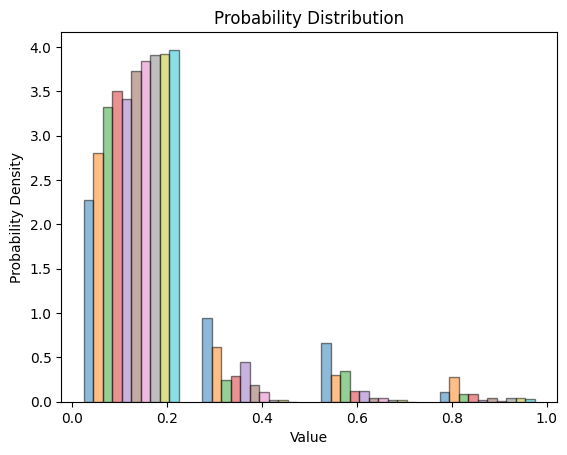

In [42]:
import matplotlib.pyplot as plt
plt.hist(proba, bins = 4, density=True, alpha=0.5,  edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Distribution')

# Show plot 
plt.show()

#i have no clue how to interpret this and why it's disjoint like this

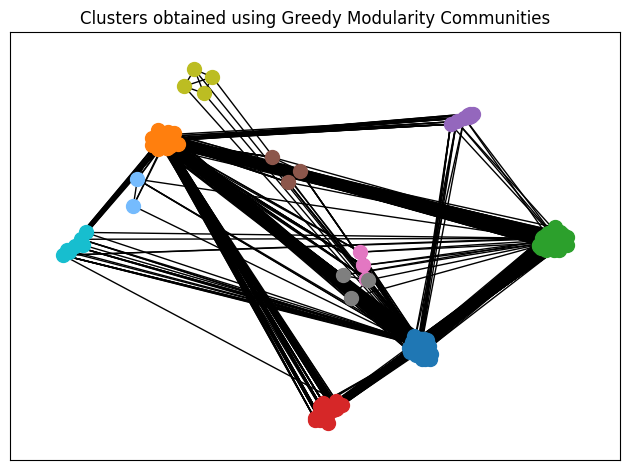

In [43]:
import matplotlib.pyplot as plt

communities_gmc = nx.community.greedy_modularity_communities(disease_projection)

# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor

supergraph = nx.cycle_graph(len(communities_gmc))
superpos = nx.spring_layout(disease_projection, scale=50, seed=420)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities_gmc):
    pos.update(nx.spring_layout(nx.subgraph(disease_projection, comm), center=center, seed=420))

# Nodes colored by cluster
for nodes, clr in zip(communities_gmc, ("tab:blue", "tab:orange", "tab:green" ,"tab:red", "tab:purple", "tab:cyan", "tab:olive", "tab:pink", "tab:gray", "tab:brown", "xkcd:sky blue")):
    nx.draw_networkx_nodes(disease_projection, pos=pos, nodelist=nodes, node_color=clr, node_size=100)
nx.draw_networkx_edges(disease_projection, pos=pos)
plt.title('Clusters obtained using Greedy Modularity Communities')
plt.tight_layout()
plt.show()

In [44]:
# find out the highest centrality nodes in each cluster

cent_data = []
for cluster in communities_gmc:
    cents = nx.degree_centrality(disease_projection.subgraph(cluster))
    max_dc = max(cents, key = cents.get)
    cent_data.append((max_dc, cents[max_dc], communities_gmc.index(cluster)))

cent_data

[('C0003873', 0.4421052631578947, 0),
 ('C1458155', 0.7028571428571428, 1),
 ('C0028754', 0.425531914893617, 2),
 ('C0023264', 0.5555555555555556, 3),
 ('C0027794', 0.7142857142857142, 4),
 ('C0004364', 0.6666666666666666, 5),
 ('C0043459', 1.0, 6),
 ('C1961099', 1.0, 7),
 ('C0035228', 1.0, 8),
 ('C0025286', 1.0, 9),
 ('C0035828', 1.0, 10)]

In [45]:
cent_data_named = [(disease_namedata[i[0]], i[1], i[2]) for i in cent_data]
for i in cent_data_named:
    print(f'Cluster ID:{i[2]}\tDisease:{i[0]}')

Cluster ID:0	Disease:Rheumatoid Arthritis
Cluster ID:1	Disease:Mammary Neoplasms
Cluster ID:2	Disease:Obesity
Cluster ID:3	Disease:Leigh Disease
Cluster ID:4	Disease:Neural Tube Defects
Cluster ID:5	Disease:Autoimmune Diseases
Cluster ID:6	Disease:Zellweger Syndrome
Cluster ID:7	Disease:Precursor T-Cell Lymphoblastic Leukemia-Lymphoma
Cluster ID:8	Disease:Respiratory Hypersensitivity
Cluster ID:9	Disease:Meningioma
Cluster ID:10	Disease:Romano-Ward Syndrome
